In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [2]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_config
from src.vit_cluster_train import ViTDeepClusterTrainer
from src.vit_data_clustering import ViTDataDeepClustering
from src.vit_data import load_cell_cycle_data
import importlib

config_name = 'deep_clustering_test'
config = importlib.import_module(f"config.{config_name}")

vit = load_model_config(config)
vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM, 
                                init_class=ViTDataDeepClustering, debug_n=None)

In [34]:
times = np.array(sorted(list(set(vit_data.times))))
times

array([  0.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 120.,
       130., 140.])

In [3]:
vit_data.all_imgs_untransformed.shape

(57551, 1, 24, 128)

In [365]:
imgs = vit_data.all_imgs_untransformed.copy()
print(imgs.shape)

(57551, 1, 24, 128)


In [279]:
from einops.layers.torch import Rearrange, Reduce

pivot = Rearrange('(t n) (i) (r) (c) -> n t i r c', t=len(times))
pivoted_imgs = pivot(torch.Tensor(imgs)).numpy()
pivoted_imgs = pivoted_imgs.reshape((pivoted_imgs.shape[0], pivoted_imgs.shape[1], 
                                         pivoted_imgs.shape[3], pivoted_imgs.shape[4]))
pivoted_imgs.shape

(4427, 13, 24, 128)

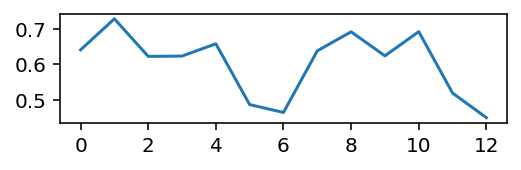

In [393]:
pvt_sum = pivoted_imgs.sum(axis=0).sum(axis=1).sum(axis=1)
scaling_factor = 2e5/pvt_sum
plt.figure(figsize=(4, 1))
plt.plot(scaling_factor)

In [394]:
scaling_tile = np.tile(scaling_factor, (pivoted_imgs.shape[3], pivoted_imgs.shape[2], 1)).T

In [395]:
scaled_pvt = (pivoted_imgs * scaling_tile)

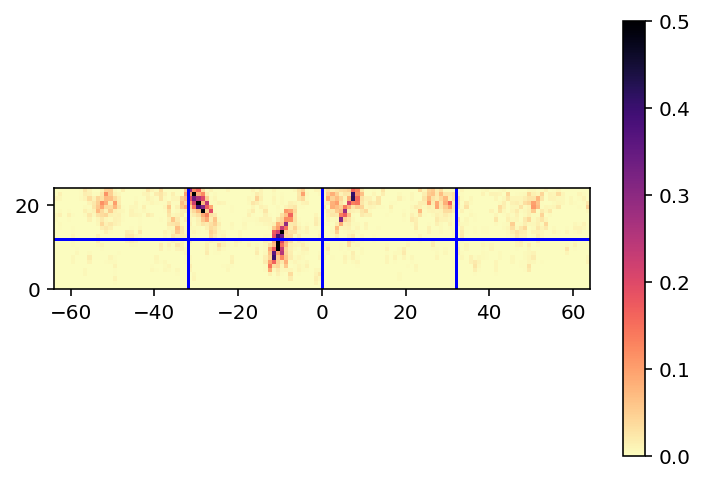

In [399]:
idx = 3427

img = scaled_pvt[idx, 0]

plt.imshow(img, origin='lower', cmap='magma_r', extent=[-64, 64, 0, 24], vmin=0, vmax=0.5)
plt.colorbar()

for x in [-32, 0, 32]:
    plt.axvline(x, c='blue')
plt.axhline(12, c='blue')

In [416]:
def plot_typhoon(idx):
    gene_name = vit_data.orfs_data.loc[vit_data.orfs[idx]]['name']
    print(gene_name)
    for i in range(len(times)):
        plt.figure(figsize=(7, 1))
        time = times[i]
        img = scaled_pvt[idx, i]

        plt.subplot(1, 3, 1)
        plt.imshow(img, origin='lower', cmap='magma_r', extent=[-64, 64, 0, 24], vmin=0, vmax=0.5, aspect='auto')
        plt.xticks([])
        plt.yticks([])
        plt.ylabel(int(time))
        for x in [-32, 0, 32]:
            plt.axvline(x, c='black', lw=1)
        plt.axhline(12, c='black', lw=1)

        plt.subplot(1, 3, 2)
        plt.imshow(normalized_pvt[idx, i], origin='lower', cmap='magma_r', vmin=0, vmax=0.001, aspect=0.85)
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(1, 3, 3)
        plt.imshow(difference[idx, i], origin='lower', cmap='RdBu', vmin=-0.001, vmax=0.001, aspect=0.85)
        plt.xticks([])
        plt.yticks([])

        plt.show()


In [401]:
import numpy as np

w = 128
h = 24

x_cutoffs = np.array([-32, 0, 32]) + w//2
y_cutoffs = np.array([0, 12, 24])

# promoter small fragments
s_p = scaled_pvt[:, :, :y_cutoffs[1], x_cutoffs[0]:x_cutoffs[1]].mean(axis=2).mean(axis=2)

# gene body small fragments
s_gb = scaled_pvt[:, :, :y_cutoffs[1], x_cutoffs[1]:x_cutoffs[2]].mean(axis=2).mean(axis=2)

# nucleosomal promoter
n_p = scaled_pvt[:, :, y_cutoffs[1]:, x_cutoffs[0]:x_cutoffs[1]].mean(axis=2).mean(axis=2)

# nucleosomal gene body
n_gb = scaled_pvt[:, :, y_cutoffs[1]:, x_cutoffs[1]:x_cutoffs[2]].mean(axis=2).mean(axis=2)

new_imgs = np.zeros((scaled_pvt.shape[0], scaled_pvt.shape[1], 2, 2))
new_imgs[:, :, 1, 0] = n_p
new_imgs[:, :, 1, 1] = n_gb
new_imgs[:, :, 0, 0] = s_p
new_imgs[:, :, 0, 1] = s_gb
simplified_quattro = new_imgs

simplified_quattro.shape

(4427, 13, 2, 2)

In [408]:
mean_img = simplified_quattro.mean(axis=1)
difference = simplified_quattro.copy()

for t in range(simplified_quattro.shape[1]):
    difference[:, t] = np.subtract(simplified_quattro[:, t], mean_img)

In [409]:
import numpy as np

def fourier_score(vals, times, period=63):
    """Fourier score from Spellman, 1998"""

    # Compute a fourier score offset by all time points within the period of 
    # the cell cycle
    offsets = np.arange(0, period, 1)
    fourier_scores = np.zeros((vals.shape[0], len(offsets)))
    for j in range(len(offsets)):
        offset = offsets[j]
        A = (vals * np.sin(period * np.array(times) + offset).reshape((-1, 1)).T).sum(axis=1)
        B = (vals * np.cos(period * np.array(times) + offset).reshape((-1, 1)).T).sum(axis=1)
        D = np.sqrt(A**2 + B**2)
        fourier_scores[:, j] = D
        
    # Take the max, the data can be offset by any point in the period, as long as the
    # data is cycling
    return fourier_scores.max(axis=1)

sm_prom_diff = difference[:, :, 1, 0]
nuc_prom_diff = difference[:, :, 0, 0]

sm_prom_fourier_score = fourier_score(sm_prom_diff[:, 1:], times[1:])
sm_fourier_idx = np.argsort(sm_prom_fourier_score)
sm_fourier_idx

array([3722, 4346, 1566, ..., 3290, 1061, 2496])

0

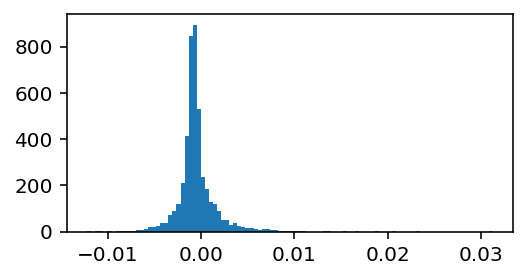

In [410]:
plt.figure(figsize=(4, 2))
plt.hist(difference[:, 0, 0, 0], bins=100)
#plt.xlim(-1, 1)
0

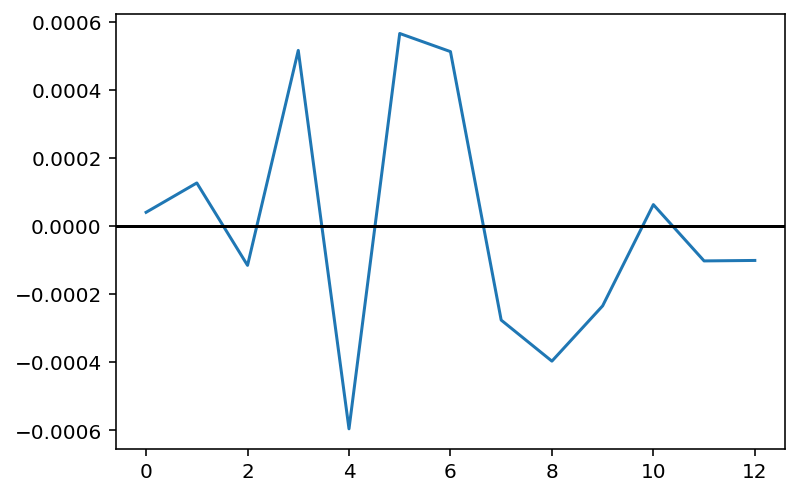

In [433]:
idx = 2496
cur_mean = simplified_quattro[idx].mean(axis=0)
cur_diff = simplified_quattro[idx] - cur_mean

plt.plot(cur_diff[:, 0, 0])
plt.axhline(0, c='black')

NFU1


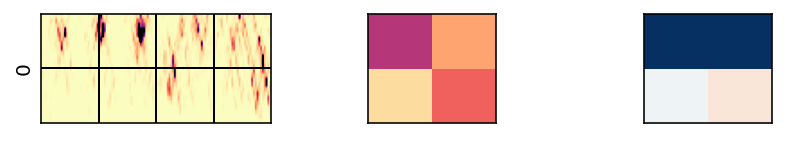

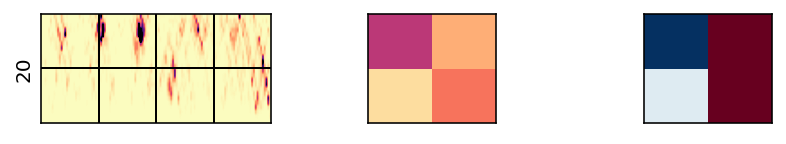

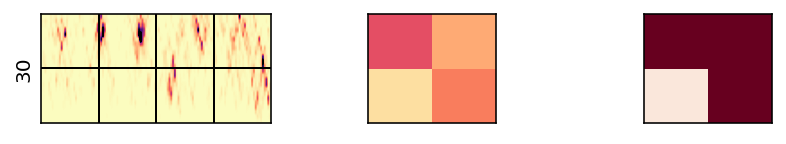

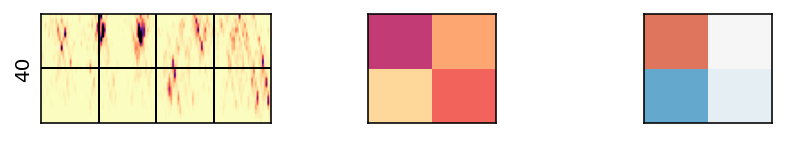

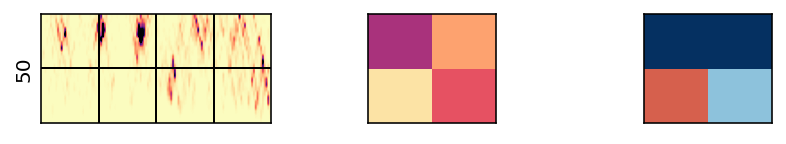

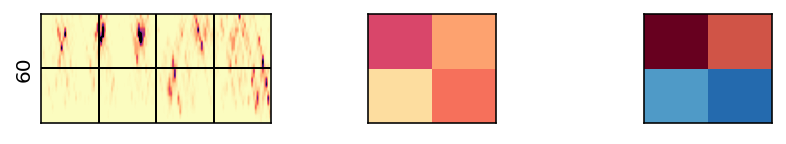

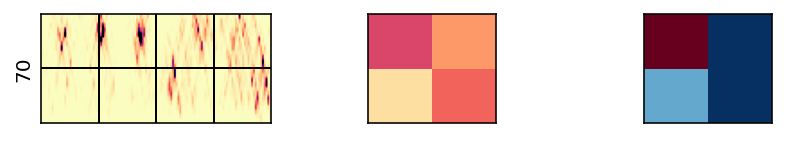

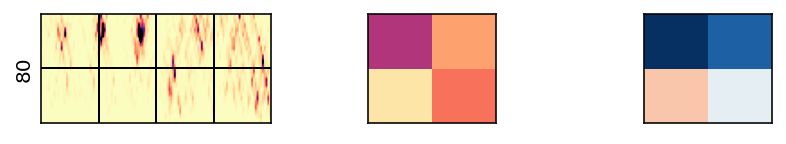

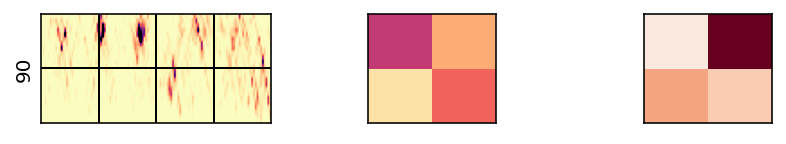

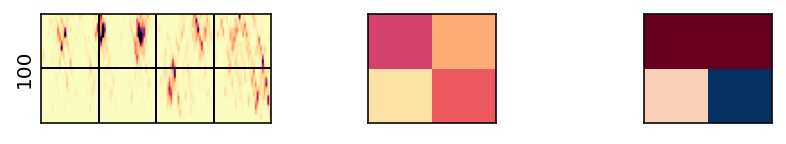

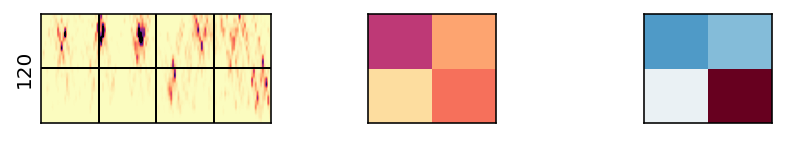

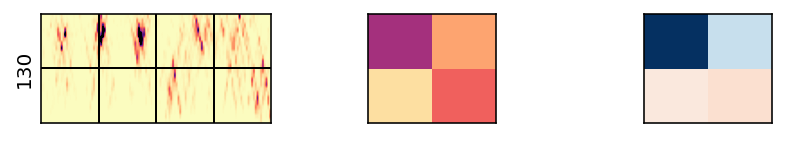

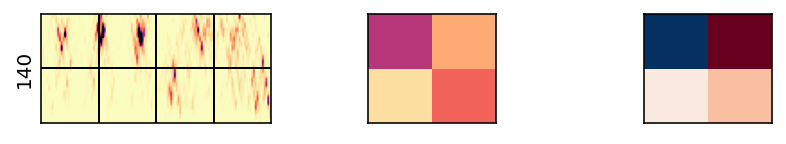

In [434]:
plot_typhoon(idx)

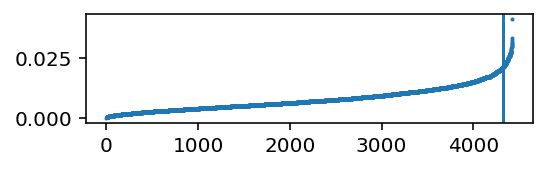

In [418]:
plt.figure(figsize=(4, 1))
plt.scatter(np.arange(len(sm_prom_fourier_score)), sm_prom_fourier_score[sm_fourier_idx], s=1)
plt.axvline(len(sm_prom_fourier_score)-100)

([], [])

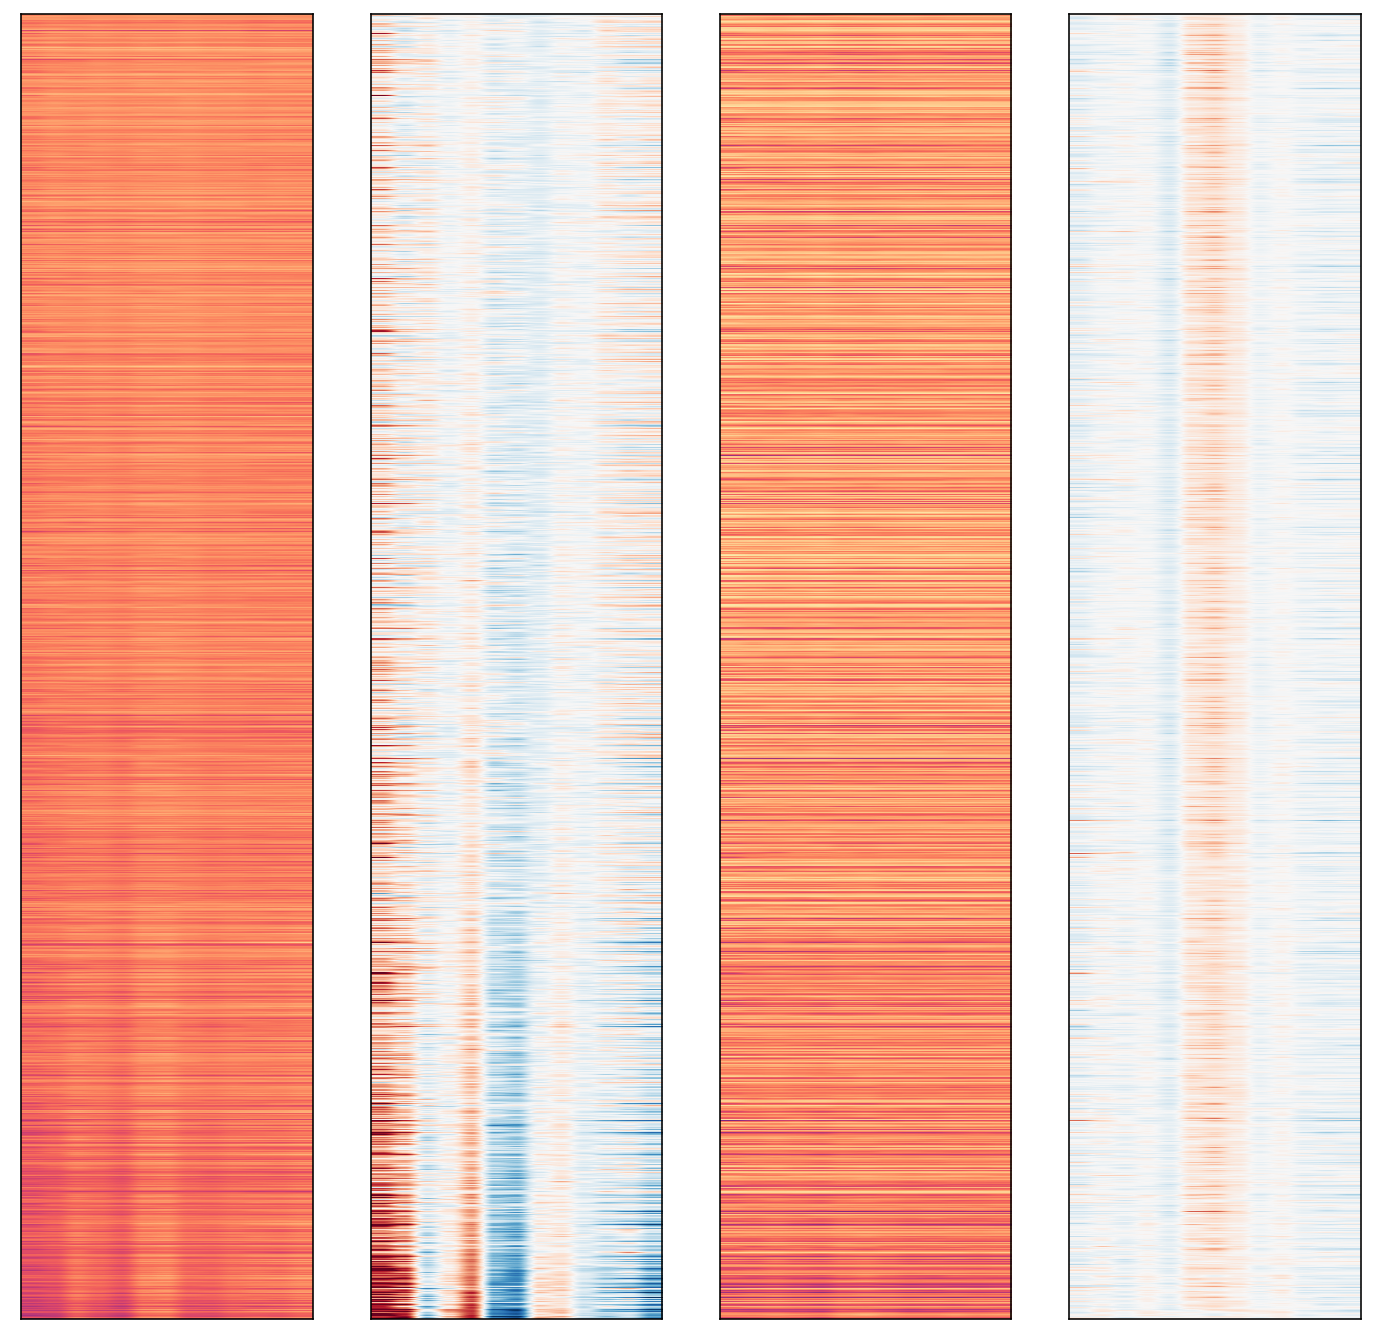

In [430]:
plt.figure(figsize=(12, 12))

plt.subplot(1, 4, 1)
plt.imshow(simplified_quattro[sm_fourier_idx][:, :, 1, 0],
           aspect='auto', cmap='magma_r', vmin=0, vmax=0.1)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 2)
plt.imshow(sm_prom_diff[sm_fourier_idx],
           aspect='auto', cmap='RdBu_r', vmin=-0.01, vmax=0.01)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 3)
plt.imshow(normalized_pvt[sm_fourier_idx][:, :, 0, 0],
           aspect='auto', cmap='magma_r', vmin=0, vmax=0.001)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 4)
plt.imshow(nuc_prom_diff[sm_fourier_idx],
           aspect='auto', cmap='RdBu_r', vmin=-0.01, vmax=0.01)
plt.yticks([])
plt.xticks([])


([], [])

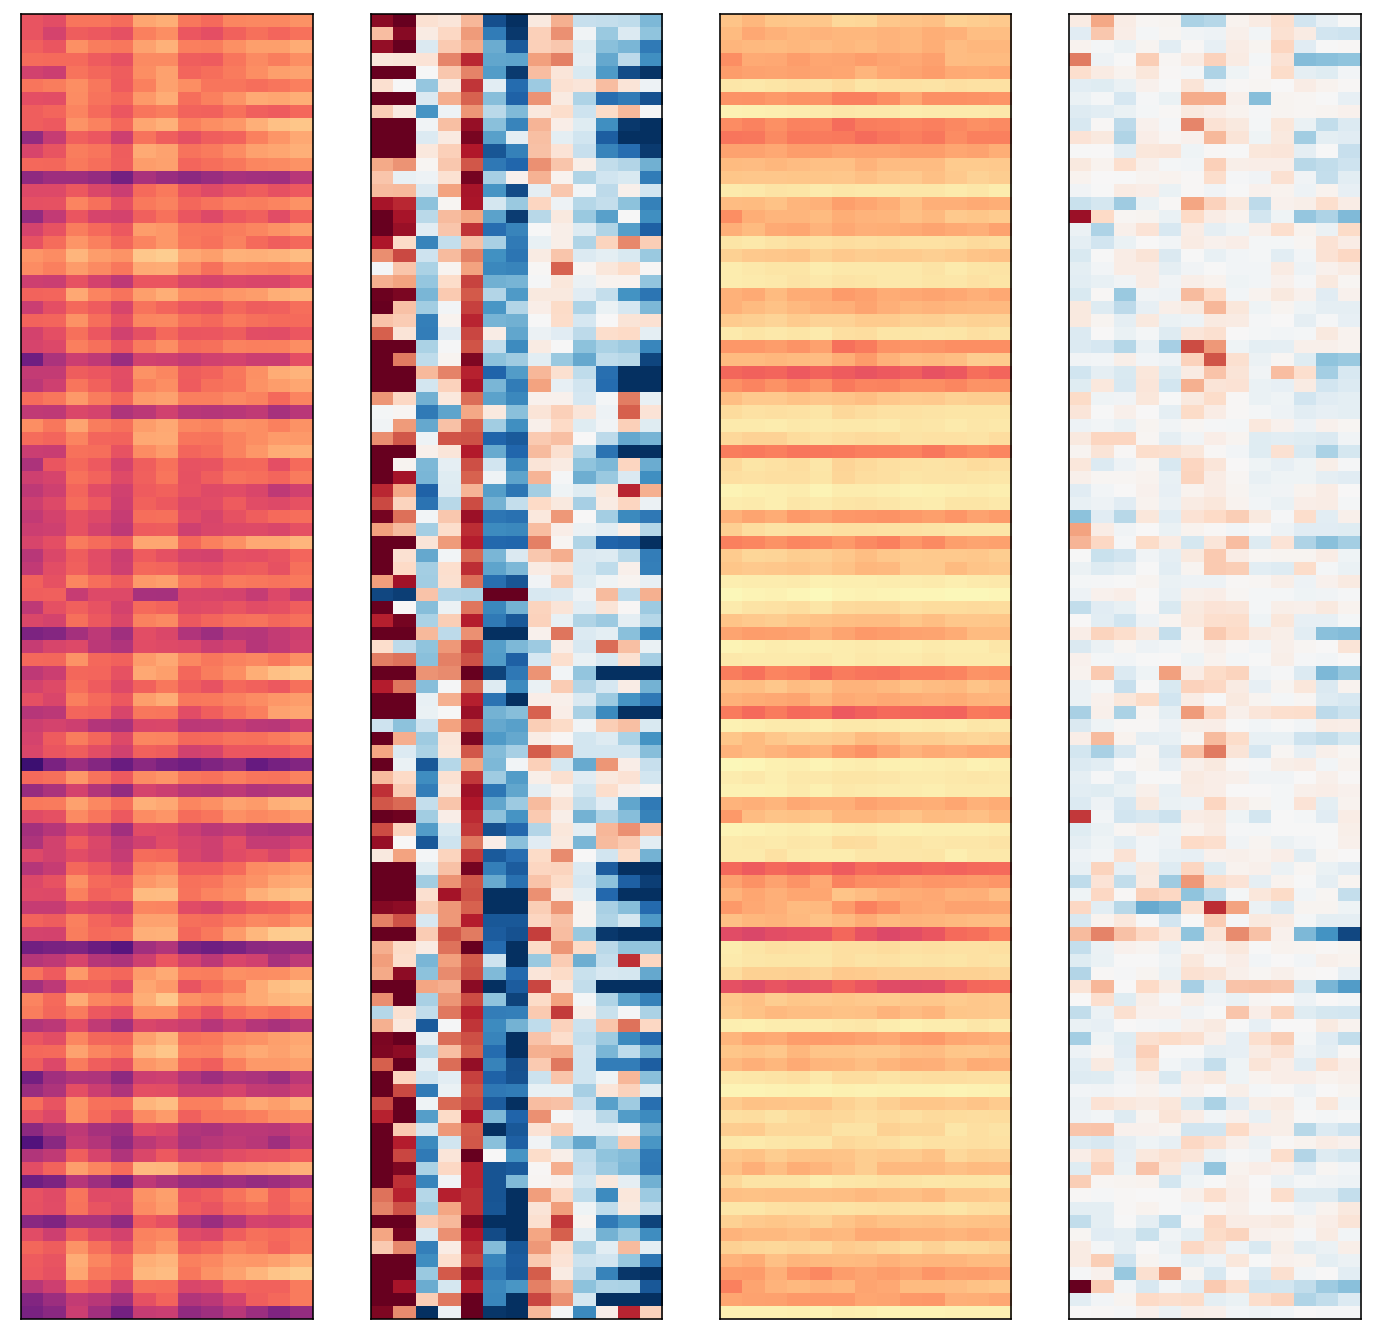

In [436]:
plt.figure(figsize=(12, 12))

plt.subplot(1, 4, 1)
plt.imshow(simplified_quattro[sm_fourier_idx][-100:, :, 1, 0],
           aspect='auto', cmap='magma_r', vmin=0, vmax=0.1)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 2)
plt.imshow(sm_prom_diff[sm_fourier_idx][-100:],
           aspect='auto', cmap='RdBu_r', vmin=-0.01, vmax=0.01)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 3)
plt.imshow(simplified_quattro[sm_fourier_idx][-100:, :, 0, 0],
           aspect='auto', cmap='magma_r', vmin=0, vmax=0.1)
plt.yticks([])
plt.xticks([])

plt.subplot(1, 4, 4)
plt.imshow(nuc_prom_diff[sm_fourier_idx][-100:],
           aspect='auto', cmap='RdBu_r', vmin=-0.01, vmax=0.01)
plt.yticks([])
plt.xticks([])


In [26]:
num_p = 0
for p in vit.parameters():
    num_p += p.reshape(-1).shape[0]
print("Number of Parameters:", num_p)

Number of Parameters: 1210


In [27]:
from torch import nn

dataloader = ViTDataLoader(vit_data, batch_size=config.BATCH_SIZE, 
            split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG,
            valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)

trainer = ViTDeepClusterTrainer(vit, config_name, dataloader, resume=False, resume_path=None, debug=True,
                                criterion=nn.MultiLabelSoftMarginLoss)

In [28]:
trainer.setup()

Directory exists. Skipping.


In [30]:
# plt.figure(figsize=(12, 2))
# plt.subplot(1, 2, 1)
# trainer.plot_pacmap_labels(plt.gca())

In [31]:
# from src.timer import Timer

# trainer.lr = 1e-2
# trainer.print_every = 2
# trainer.setup()

# trainer.train(total_epochs=101)/


In [32]:
# plt.figure(figsize=(16, 2))
# plt.subplot(1, 3, 1)
# trainer.plot_pacmap_labels(plt.gca())

# plt.subplot(1, 3, 2)
# plt.plot(trainer.epochs_arr, trainer.train_losses)
# plt.ylim(0, 2.0)

# plt.subplot(1, 3, 3)
# for c in range(4):
#     plt.plot(trainer.epochs_arr, np.array(trainer.proportions[c])/len(vit_data)*100.)
# plt.ylim(0, 100)


In [33]:
# for c in range(4):
#     plt.figure(figsize=(18, 1))
#     for i in range(3):
#         plt.subplot(1, 3, i+1)
#         plt.imshow(vit_data.all_imgs[vit_data.pseudo_labels == c][-i][0], origin='lower',
#                   cmap='magma_r', vmin=-1, vmax=-0.5)
#         plt.xticks([])
#         plt.yticks([])
#     plt.show()